# Sentiment Classification - Financial Statements
### Import Libraries & Load Data

In [1]:
import numpy as np 
import pandas as pd 

import os
import re
import time
import datetime
import string

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from collections import Counter, defaultdict

import transformers
from transformers import BertModel, BertTokenizer, DistilBertTokenizer, RobertaModel, RobertaTokenizer
from transformers import AutoConfig, AutoModel, AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn, optim
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
statement_df = pd.read_csv('../input/sentiment-analysis-for-financial-news/all-data.csv', encoding='latin-1', header=None)
statement_df.columns = ['sentiment', 'statement']

### Set Device and Apply Random Seed

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

RANDOM_SEED = 73
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

### Exploratory Data Analysis

In [4]:
statement_df.head()

,sentiment,statement
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [5]:
statement_df.shape

(4846, 2)

#### Check for Missing Data

In [6]:
statement_df.isna().sum()

sentiment    0
statement    0
dtype: int64

#### Remove Duplicate Entries

In [7]:
print('Number of Duplicate Entries: ', len(statement_df[statement_df.duplicated()]))

Number of Duplicate Entries:  6


In [8]:
statement_df = statement_df.drop_duplicates()

### Clean Statements

In [9]:
def clean_statements(statement):
    statement = re.sub(" '", "'", statement)
    statement = re.sub(" 's", "'s", statement)
    statement = re.sub('\( ', '(', statement)
    statement = re.sub(' \)', ')', statement)
    statement = re.sub('``', '"', statement)
    statement = re.sub("''", '"', statement)
    statement = re.sub(r'\s([?.,%:!"](?:\s|$))', r'\1', statement)
#     statement = statement.translate(str.maketrans('', '', string.punctuation))
    return statement

In [10]:
statement_df['statement'] = statement_df['statement'].apply(clean_statements)

### Split Statements into Words and Characters

In [11]:
statement_df['num_char'] = statement_df['statement'].apply(len)
statement_df['num_words'] = statement_df['statement'].apply(lambda x: len(x.split()))

#### Number of Class Examples

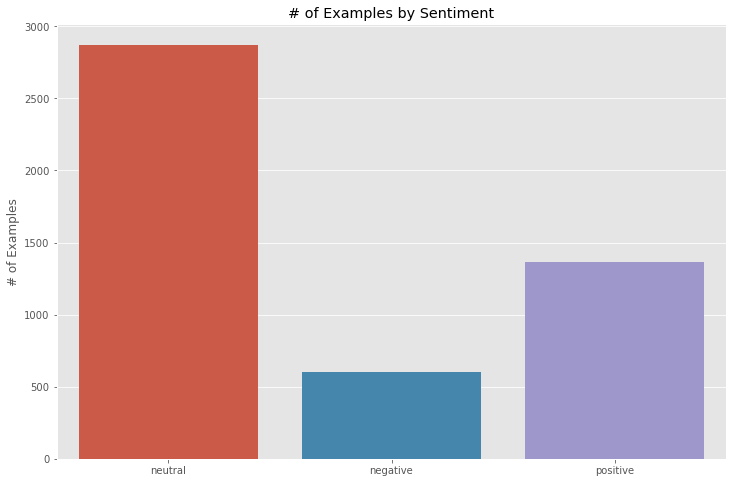

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(x='sentiment', data=statement_df)
plt.xlabel('')
plt.ylabel('# of Examples')
plt.title('# of Examples by Sentiment')
plt.show()

#### Number of Characters by Class

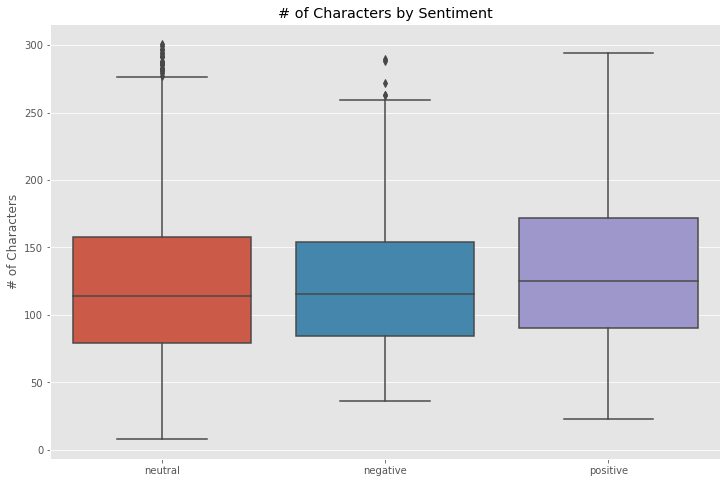

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x='sentiment', y='num_char', data=statement_df)
plt.xlabel('')
plt.ylabel('# of Characters')
plt.title('# of Characters by Sentiment')
plt.show()

#### Number of Words by Class

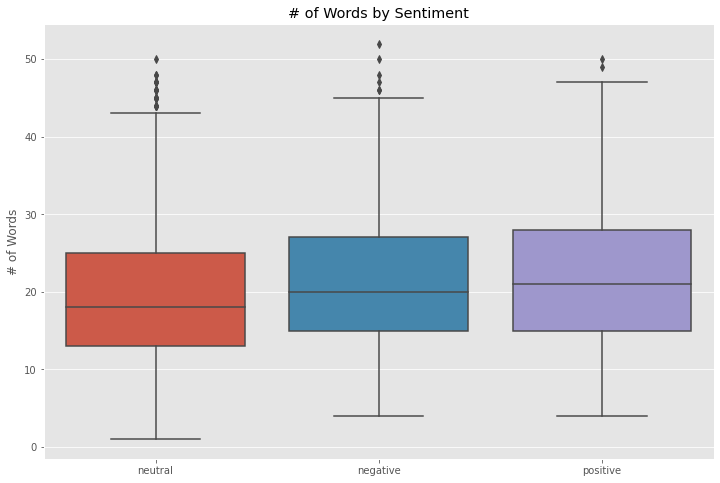

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x='sentiment', y='num_words', data=statement_df)
plt.xlabel('')
plt.ylabel('# of Words')
plt.title('# of Words by Sentiment')
plt.show()

#### Identify Longest and Shortest Statements

In [15]:
print('Longest Statement: ', statement_df['num_words'].max(), 'words.')

Longest Statement:  52 words.


In [16]:
print('Shortest Statement: ', statement_df['num_words'].min(), 'words.')

Shortest Statement:  1 words.


In [17]:
pos_statements = ' '.join(statement_df.loc[statement_df['sentiment'] == 'positive']['statement'].values)
neg_statements = ' '.join(statement_df.loc[statement_df['sentiment'] == 'negative']['statement'].values)
neutral_statements = ' '.join(statement_df.loc[statement_df['sentiment'] == 'neutral']['statement'].values)

In [18]:
pos_statements = re.sub('[^A-Za-z]+', ' ', pos_statements).strip().lower()
neg_statements = re.sub('[^A-Za-z]+', ' ', neg_statements).strip().lower()
neutral_statements = re.sub('[^A-Za-z]+', ' ', neutral_statements).strip().lower()

In [19]:
pos_tokens = word_tokenize(pos_statements)
neg_tokens = word_tokenize(neg_statements)
neutral_tokens = word_tokenize(neutral_statements)

In [20]:
stop_words = stopwords.words('english')

In [21]:
pos_tokens_nostop = [w for w in pos_tokens if w not in stop_words]
neg_tokens_nostop = [w for w in neg_tokens if w not in stop_words]
neutral_tokens_nostop = [w for w in neutral_tokens if w not in stop_words]

In [22]:
pos_freq = Counter(pos_tokens_nostop)
neg_freq = Counter(neg_tokens_nostop)
neutral_freq = Counter(neutral_tokens_nostop)

In [23]:
top_10_pos = pos_freq.most_common()[:10]
top_10_neg = neg_freq.most_common()[:10]
top_10_neutral = neutral_freq.most_common()[:10]

In [24]:
def get_ngrams(input, n):
    return [tuple(input[i:i+n]) for i in range(len(input) - n + 1)]

In [25]:
top_10_pos

[('eur', 639),
 ('mn', 264),
 ('company', 241),
 ('said', 230),
 ('year', 212),
 ('finnish', 202),
 ('net', 196),
 ('sales', 192),
 ('profit', 192),
 ('million', 170)]

In [26]:
top_10_neg

[('eur', 417),
 ('mn', 237),
 ('profit', 156),
 ('net', 104),
 ('finnish', 102),
 ('company', 100),
 ('year', 100),
 ('sales', 98),
 ('operating', 97),
 ('period', 90)]

In [27]:
top_10_neutral

[('company', 508),
 ('eur', 359),
 ('said', 238),
 ('finland', 227),
 ('finnish', 220),
 ('business', 195),
 ('million', 193),
 ('new', 189),
 ('group', 187),
 ('sales', 165)]

# Sentiment Analysis

In [28]:
MAX_LENGTH = 64
BATCH_SIZE = 16
NUM_CLASSES = 3
EPOCHS = 5
DROPOUT_PROB = 0.1
WEIGHT_DECAY = 0.01
NFOLDS = 10
LEARNING_RATE = 2e-5

In [29]:
le = LabelEncoder()
statement_df['sentiment'] = le.fit_transform(statement_df['sentiment'])

In [30]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [31]:
class StatementDataset(Dataset):
    
    def __init__(self, statements, labels, tokenizer, max_length):
        self.statements = statements
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        
        return len(self.statements)
    
    def __getitem__(self, idx):
        
        statement = str(self.statements[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            statement,
            max_length=self.max_length,
            padding='max_length',
            add_special_tokens=True, 
            return_token_type_ids=False,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'  
        ) 
        
        return {
            'statement_text': statement,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }
        

In [32]:
df_train, df_test = train_test_split(statement_df, 
                                     test_size=0.2, 
                                     random_state=RANDOM_SEED, 
                                     stratify=statement_df['sentiment'].values)

df_val, df_test = train_test_split(df_test, 
                                   test_size=0.5, 
                                   random_state=RANDOM_SEED, 
                                   stratify=df_test['sentiment'].values)

df_train_full = pd.concat([df_train, df_val])

In [33]:
def create_dataset(df, tokenizer, max_length):
    ds = StatementDataset(statements=df['statement'].to_numpy(),
                          labels=df['sentiment'].to_numpy(),
                          tokenizer=tokenizer,
                          max_length=max_length)
    return ds

def create_dataloader(ds, batch_size):
    return DataLoader(ds, batch_size, num_workers=4)
    

In [34]:
def cv_ensemble_performance(preds, labels):
    preds = np.array(preds)
    summed = np.sum(preds, axis=0)
    preds = np.argmax(summed, axis=1)
    print(confusion_matrix(y_true=labels, y_pred=preds))
    print('')
    print(classification_report(y_true=labels, y_pred=preds, digits=3, target_names=le.classes_))
    
def single_model_performance(preds, labels):
    print(confusion_matrix(y_true=labels, y_pred=preds))
    print('')
    print(classification_report(y_true=labels, y_pred=preds, digits=3, target_names=le.classes_))

In [35]:
def train_model(model, device, data_loader, loss_function, 
                optimizer, scheduler, n_examples):
    
    model = model.train()
    losses = []
    correct_preds = 0
    complete_preds = []
    complete_labels = []
    
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
        _, preds = torch.max(outputs, dim=1)
        loss = loss_function(outputs, labels)
        complete_preds.append(preds.data.cpu().numpy().tolist())
        complete_labels.append(labels.data.cpu().numpy().tolist())
        correct_preds += torch.sum(preds == labels)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    complete_preds_flat = [x for y in complete_preds for x in y]
    complete_labels_flat = [x for y in complete_labels for x in y]
    acc_score = accuracy_score(y_true=complete_labels_flat, 
                             y_pred=complete_preds_flat)
    return acc_score, np.mean(losses)
        

In [36]:
def eval_model(model, device, data_loader, loss_function, n_examples):
    model = model.eval()
    
    losses = []
    correct_preds = 0
    complete_preds = []
    complete_labels = []
    complete_outputs = []
    
    with torch.no_grad():
        for item in data_loader:
            input_ids = item['input_ids'].to(device)
            attention_mask = item['attention_mask'].to(device)
            labels = item['labels'].to(device)

            outputs = model(input_ids=input_ids, 
                            attention_mask=attention_mask)
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_function(outputs, labels)
            
            correct_preds += torch.sum(preds == labels)
            complete_preds.append(preds.data.cpu().numpy().tolist())
            complete_labels.append(labels.data.cpu().numpy().tolist())
            complete_outputs.append(outputs.tolist())
            losses.append(loss.item())
        
        accuracy = correct_preds.double() / n_examples
        complete_preds_flat = [x for y in complete_preds for x in y]
        complete_labels_flat = [x for y in complete_labels for x in y]
        complete_outputs_flat = [x for y in complete_outputs for x in y]

        acc_score = accuracy_score(y_true=complete_labels_flat, 
                             y_pred=complete_preds_flat)
        
        return_items = (acc_score, 
                        np.mean(losses), 
                        complete_preds_flat, 
                        complete_outputs_flat)
        
        return return_items

In [37]:
def train_fold(epochs, model, device, train_dataloader, 
               val_dataloader, test_dataloader, loss_fn, optimizer, 
               scheduler, model_save_name, n_train, n_val, single_model=True):
    
    start_time = time.time()
    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(epochs):
        epoch_start_time = time.time()
        print('Epoch ', epoch+1, '/', epochs)
        print('-'*50)

        training_output = train_model(model, 
                                      device, 
                                      train_dataloader, 
                                      loss_fn, 
                                      optimizer, 
                                      scheduler, 
                                      n_train)
        
        train_acc, train_loss = training_output
        
        val_output = eval_model(model, 
                                device, 
                                val_dataloader, 
                                loss_fn, 
                                n_val)

        val_acc, val_loss, val_preds, val_outputs = val_output
        
        history['train_accuracy'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_accuracy'].append(val_acc)
        history['val_loss'].append(val_loss)
        history['val_preds'].append(val_preds)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), model_save_name)
            best_accuracy = val_acc
            best_preds = val_preds
            best_outputs = val_outputs

        print('Train Loss: ', 
              train_loss, 
              ' | ', 
              'Train Accuracy: ', 
              train_acc)
        print('Val Loss: ', 
              val_loss, 
              ' | ', 
              'Val Accuracy: ', 
              val_acc)
        print('Epoch Train Time: ', 
              format_time(time.time() - epoch_start_time))
        print('\n')
    
    print('Finished Training.')   
    print('Fold Train Time: ', format_time(time.time() - start_time))
    print('\n')
    if single_model:
        _, _, test_preds, test_outputs = eval_model(model, 
                                                    device, 
                                                    test_dataloader, 
                                                    loss_function, 
                                                    len(df_test))
        
        single_model_performance(test_preds, df_test['sentiment'].values)
    return history, best_preds, best_outputs

In [38]:
def get_oof_and_test_preds(model_type, tokenizer, 
                           train_df, test_df, single_model=False):
    oof_preds = []
    oof_outputs = []
    oof_preds_indices = []
    test_preds_list = []
    test_outputs_list = []
    history_list = []
    start_time = time.time()
    
    fold = 0
    
    x_train = train_df['statement']
    y_train = train_df['sentiment']

    for train_index, val_index in skf.split(x_train, y_train):
        print('Fold: {}'.format(fold+1))
        
        x_tr = x_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        x_va = x_train.iloc[val_index]
        y_va = y_train.iloc[val_index]
        
        train = pd.DataFrame(list(zip(x_tr, y_tr)), 
                             columns=['statement', 'sentiment'])
        val = pd.DataFrame(list(zip(x_va, y_va)), 
                           columns=['statement', 'sentiment'])

        train_ds = create_dataset(train, tokenizer, MAX_LENGTH)
        val_ds = create_dataset(val, tokenizer, MAX_LENGTH)
        test_ds = create_dataset(test_df, tokenizer, MAX_LENGTH)
        

        if model_type == 'bert':
            model = BERTSentimentClassifier(NUM_CLASSES)
            model = model.to(device)
        elif model_type == 'distilbert':
            model = DistilBertForSequenceClassification(pretrained_model_name=DISTILBERT_MODEL_NAME, 
                                                        num_classes=NUM_CLASSES)
            model = model.to(device)
        elif model_type == 'roberta':
            model = RobertaSentimentClassifier(n_classes=NUM_CLASSES)
            model = model.to(device)
        
        train_loader = create_dataloader(train_ds, BATCH_SIZE)
        val_loader = create_dataloader(val_ds, BATCH_SIZE)
        test_loader = create_dataloader(test_ds, BATCH_SIZE)
        
        training_steps = len(train_loader.dataset) * EPOCHS
        warmup_steps = int(0.1 * training_steps)
        optimizer = AdamW(model.parameters(), 
                          lr=LEARNING_RATE, 
                          weight_decay=WEIGHT_DECAY, 
                          correct_bias=True)
        scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps=warmup_steps, 
                                                    num_training_steps=training_steps)
        
        model_save_name = '{}_fold_{}.bin'.format(model_type, fold)
        
        history, preds, outputs = train_fold(epochs=EPOCHS,
                                             model=model, 
                                             device=device, 
                                             train_dataloader=train_loader, 
                                             val_dataloader=val_loader,
                                             test_dataloader=test_loader,
                                             loss_fn=loss_function,
                                             optimizer=optimizer,
                                             scheduler=scheduler,
                                             model_save_name=model_save_name,
                                             n_train=len(train),
                                             n_val=len(val),
                                             single_model=False
                                            )
        
        history_list.append(history)
        oof_preds.append(preds)
        oof_outputs.append(outputs)
        oof_preds_indices.append(val_index)
        _, _, test_preds, test_outputs = eval_model(model, 
                                                    device, 
                                                    test_loader, 
                                                    loss_function, 
                                                    len(test_df))
        test_preds_list.append(test_preds)
        test_outputs_list.append(test_outputs)
        
        fold += 1

    print(str(NFOLDS), 'Fold CV Train Time: ', format_time(time.time() - start_time))

    return history_list, test_outputs_list
        

In [39]:
loss_function = nn.CrossEntropyLoss().to(device)

In [40]:
skf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=RANDOM_SEED)

## BERT

### Single Model

In [41]:
BERT_MODEL_NAME = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [42]:
bert_train_ds = create_dataset(df_train, bert_tokenizer, MAX_LENGTH)
bert_test_ds = create_dataset(df_test, bert_tokenizer, MAX_LENGTH)
bert_val_ds = create_dataset(df_val, bert_tokenizer, MAX_LENGTH)

bert_train_dataloader = create_dataloader(bert_train_ds, BATCH_SIZE)
bert_test_dataloader = create_dataloader(bert_test_ds, BATCH_SIZE)
bert_val_dataloader = create_dataloader(bert_val_ds, BATCH_SIZE)

In [43]:
class BERTSentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(BERTSentimentClassifier, self).__init__()
        self.model = BertModel.from_pretrained(BERT_MODEL_NAME)
        self.drop = nn.Dropout(DROPOUT_PROB)
        self.output = nn.Linear(self.model.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.model(
            input_ids = input_ids,
            attention_mask=attention_mask
        )

        output = self.drop(pooled_output)
        
        return self.output(output)

In [44]:
bert_model = BERTSentimentClassifier(NUM_CLASSES)
bert_model = bert_model.to(device)

In [45]:
training_steps = len(bert_train_dataloader.dataset) * EPOCHS

bert_optimizer = AdamW(bert_model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY, 
                       correct_bias=True)

warmup_steps = int(0.1 * training_steps)
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer, 
                                                 num_warmup_steps=warmup_steps, 
                                                 num_training_steps=training_steps)

In [46]:
bert_single_model_items = train_fold(epochs=EPOCHS, 
                                     model=bert_model, 
                                     device=device, 
                                     train_dataloader=bert_train_dataloader, 
                                     val_dataloader=bert_val_dataloader,
                                     test_dataloader=bert_test_dataloader,
                                     loss_fn=loss_function,
                                     optimizer=bert_optimizer,
                                     scheduler=bert_scheduler,
                                     model_save_name='bert_best_model.bin',
                                     n_train=len(df_train),
                                     n_val=len(df_val),
                                     single_model=True
                                    )

Epoch  1 / 5
--------------------------------------------------
Train Loss:  0.9926277940923517  |  Train Accuracy:  0.4981921487603306
Val Loss:  0.7699596381956532  |  Val Accuracy:  0.6735537190082644
Epoch Train Time:  0:00:35


Epoch  2 / 5
--------------------------------------------------
Train Loss:  0.6985195621478656  |  Train Accuracy:  0.6934400826446281
Val Loss:  0.5261421915023557  |  Val Accuracy:  0.7975206611570248
Epoch Train Time:  0:00:35


Epoch  3 / 5
--------------------------------------------------
Train Loss:  0.45097066311181083  |  Train Accuracy:  0.8316115702479339
Val Loss:  0.3488022932602513  |  Val Accuracy:  0.8657024793388429
Epoch Train Time:  0:00:35


Epoch  4 / 5
--------------------------------------------------
Train Loss:  0.2888139240474494  |  Train Accuracy:  0.8954028925619835
Val Loss:  0.35467278236343014  |  Val Accuracy:  0.878099173553719
Epoch Train Time:  0:00:34


Epoch  5 / 5
--------------------------------------------------
Tra

### 10-Fold CV

In [47]:
bert_history, bert_test_outputs = get_oof_and_test_preds(model_type='bert', 
                                                         tokenizer=bert_tokenizer, 
                                                         train_df=df_train_full, 
                                                         test_df=df_test,
                                                         single_model=False)

Fold: 1
Epoch  1 / 5
--------------------------------------------------
Train Loss:  0.9999292215522455  |  Train Accuracy:  0.5099489795918367
Val Loss:  0.8584627445255008  |  Val Accuracy:  0.6192660550458715
Epoch Train Time:  0:00:34


Epoch  2 / 5
--------------------------------------------------
Train Loss:  0.7108871262900683  |  Train Accuracy:  0.6910714285714286
Val Loss:  0.46267955005168915  |  Val Accuracy:  0.8142201834862385
Epoch Train Time:  0:00:36


Epoch  3 / 5
--------------------------------------------------
Train Loss:  0.41067103086685647  |  Train Accuracy:  0.8441326530612245
Val Loss:  0.36391209731144564  |  Val Accuracy:  0.8440366972477065
Epoch Train Time:  0:00:36


Epoch  4 / 5
--------------------------------------------------
Train Loss:  0.2846046985108025  |  Train Accuracy:  0.8987244897959183
Val Loss:  0.39975788683763575  |  Val Accuracy:  0.8463302752293578
Epoch Train Time:  0:00:35


Epoch  5 / 5
-------------------------------------------

In [48]:
cv_ensemble_performance(bert_test_outputs, df_test['sentiment'].values)

[[ 54   5   2]
 [  6 259  22]
 [  1  17 118]]

              precision    recall  f1-score   support

    negative      0.885     0.885     0.885        61
     neutral      0.922     0.902     0.912       287
    positive      0.831     0.868     0.849       136

    accuracy                          0.890       484
   macro avg      0.879     0.885     0.882       484
weighted avg      0.892     0.890     0.891       484



## DistilBERT
### Single Model

In [49]:
DISTILBERT_MODEL_NAME = 'distilbert-base-uncased'
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(DISTILBERT_MODEL_NAME)

In [50]:
distilbert_train_ds = create_dataset(df_train, distilbert_tokenizer, MAX_LENGTH)
distilbert_test_ds = create_dataset(df_test, distilbert_tokenizer, MAX_LENGTH)
distilbert_val_ds = create_dataset(df_val, distilbert_tokenizer, MAX_LENGTH)

distilbert_train_dataloader = create_dataloader(distilbert_train_ds, BATCH_SIZE)
distilbert_test_dataloader = create_dataloader(distilbert_test_ds, BATCH_SIZE)
distilbert_val_dataloader = create_dataloader(distilbert_val_ds, BATCH_SIZE)

In [51]:
class DistilBertForSequenceClassification(nn.Module):

    def __init__(self, pretrained_model_name, num_classes):

        super().__init__()

        config = AutoConfig.from_pretrained(pretrained_model_name, num_labels=num_classes)

        self.distilbert = AutoModel.from_pretrained(pretrained_model_name, config=config)
        self.pre_classifier = nn.Linear(config.dim, config.dim)
        self.classifier = nn.Linear(config.dim, num_classes)
        self.dropout = nn.Dropout(config.seq_classif_dropout)

    def forward(self, input_ids, attention_mask=None, head_mask=None):

        assert attention_mask is not None, "No Attention Mask"
        distilbert_output = self.distilbert(input_ids=input_ids,
                                            attention_mask=attention_mask,
                                            head_mask=head_mask)

        hidden_state = distilbert_output[0]  
        pooled_output = hidden_state[:, 0] 
        pooled_output = self.pre_classifier(pooled_output)  
        pooled_output = nn.ReLU()(pooled_output)  
        pooled_output = self.dropout(pooled_output)  
        logits = self.classifier(pooled_output)  

        return logits

In [52]:
distilbert_model = DistilBertForSequenceClassification(pretrained_model_name=DISTILBERT_MODEL_NAME, num_classes=NUM_CLASSES)
distilbert_model = distilbert_model.to(device)

In [53]:
training_steps = len(distilbert_train_dataloader.dataset) * EPOCHS

distilbert_optimizer = AdamW(distilbert_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, correct_bias=True)
distilbert_scheduler = get_linear_schedule_with_warmup(distilbert_optimizer, num_warmup_steps=int(0.1 * training_steps), num_training_steps=training_steps)

In [54]:
distilbert_history, distilbert_preds, distilbert_outputs, = train_fold(epochs=EPOCHS,
                                                                       model=distilbert_model,
                                                                       device=device, 
                                                                       train_dataloader=distilbert_train_dataloader, 
                                                                       val_dataloader=distilbert_val_dataloader,
                                                                       test_dataloader=distilbert_test_dataloader,
                                                                       loss_fn=loss_function,
                                                                       optimizer=distilbert_optimizer,
                                                                       scheduler=distilbert_scheduler,
                                                                       model_save_name='distilbest_best_model.bin',
                                                                       n_train=len(df_train),
                                                                       n_val=len(df_val),
                                                                       single_model=True
                                                                      )

Epoch  1 / 5
--------------------------------------------------
Train Loss:  1.0174256366146497  |  Train Accuracy:  0.5247933884297521
Val Loss:  0.8844125674616906  |  Val Accuracy:  0.5950413223140496
Epoch Train Time:  0:00:19


Epoch  2 / 5
--------------------------------------------------
Train Loss:  0.7230734325144902  |  Train Accuracy:  0.6867252066115702
Val Loss:  0.5096909221141569  |  Val Accuracy:  0.8016528925619835
Epoch Train Time:  0:00:20


Epoch  3 / 5
--------------------------------------------------
Train Loss:  0.43774399130551284  |  Train Accuracy:  0.828254132231405
Val Loss:  0.34935386671173957  |  Val Accuracy:  0.8615702479338843
Epoch Train Time:  0:00:20


Epoch  4 / 5
--------------------------------------------------
Train Loss:  0.32051020892998894  |  Train Accuracy:  0.8778409090909091
Val Loss:  0.34033183741473383  |  Val Accuracy:  0.871900826446281
Epoch Train Time:  0:00:19


Epoch  5 / 5
--------------------------------------------------
Tr

### 10-Fold CV

In [55]:
distilbert_history, distilbert_test_outputs = get_oof_and_test_preds(model_type='distilbert', 
                                                                                                                                                                        tokenizer=distilbert_tokenizer, 
                                                                                                                                                                        train_df=df_train_full, 
                                                                                                                                                                        test_df=df_test,
                                                                                                                                                                        single_model=False)

Fold: 1
Epoch  1 / 5
--------------------------------------------------
Train Loss:  1.0293812131395146  |  Train Accuracy:  0.45663265306122447
Val Loss:  0.8766298357929502  |  Val Accuracy:  0.5986238532110092
Epoch Train Time:  0:00:20


Epoch  2 / 5
--------------------------------------------------
Train Loss:  0.7156587053318413  |  Train Accuracy:  0.689795918367347
Val Loss:  0.5239637227995055  |  Val Accuracy:  0.8004587155963303
Epoch Train Time:  0:00:20


Epoch  3 / 5
--------------------------------------------------
Train Loss:  0.43323043420606727  |  Train Accuracy:  0.835969387755102
Val Loss:  0.36729702406695913  |  Val Accuracy:  0.8623853211009175
Epoch Train Time:  0:00:19


Epoch  4 / 5
--------------------------------------------------
Train Loss:  0.3136976310793234  |  Train Accuracy:  0.878061224489796
Val Loss:  0.36658207167472157  |  Val Accuracy:  0.8577981651376146
Epoch Train Time:  0:00:19


Epoch  5 / 5
----------------------------------------------

In [56]:
cv_ensemble_performance(distilbert_test_outputs, df_test['sentiment'].values)

[[ 55   5   1]
 [  8 255  24]
 [  5  16 115]]

              precision    recall  f1-score   support

    negative      0.809     0.902     0.853        61
     neutral      0.924     0.889     0.906       287
    positive      0.821     0.846     0.833       136

    accuracy                          0.878       484
   macro avg      0.851     0.879     0.864       484
weighted avg      0.881     0.878     0.879       484



## RoBERTa
### Single Model

In [57]:
ROBERTA_MODEL_NAME = 'roberta-base'
roberta_tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_MODEL_NAME)

In [58]:
roberta_train_ds = create_dataset(df_train, roberta_tokenizer, MAX_LENGTH)
roberta_test_ds = create_dataset(df_test, roberta_tokenizer, MAX_LENGTH)
roberta_val_ds = create_dataset(df_val, roberta_tokenizer, MAX_LENGTH)

roberta_train_dataloader = create_dataloader(roberta_train_ds, BATCH_SIZE)
roberta_test_dataloader = create_dataloader(roberta_test_ds, BATCH_SIZE)
roberta_val_dataloader = create_dataloader(roberta_val_ds, BATCH_SIZE)

In [59]:
class RobertaSentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(RobertaSentimentClassifier, self).__init__()
        self.model = RobertaModel.from_pretrained(ROBERTA_MODEL_NAME)
        self.drop = nn.Dropout(DROPOUT_PROB)
        self.output = nn.Linear(self.model.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.model(
            input_ids = input_ids,
            attention_mask=attention_mask
        )
        
        output = self.drop(pooled_output)
        
        return self.output(output)

In [60]:
roberta_model = RobertaSentimentClassifier(n_classes=NUM_CLASSES)
roberta_model = roberta_model.to(device)

In [61]:
training_steps = len(roberta_train_dataloader.dataset) * EPOCHS

roberta_optimizer = AdamW(roberta_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, correct_bias=True)
roberta_scheduler = get_linear_schedule_with_warmup(roberta_optimizer, num_warmup_steps=int(0.1 * training_steps), num_training_steps=training_steps)

In [62]:
roberta_single_model_items = train_fold(epochs=EPOCHS,
                                                              model=roberta_model,
                                                              device=device, 
                                                              train_dataloader=roberta_train_dataloader, 
                                                              val_dataloader=roberta_val_dataloader,
                                                              test_dataloader=roberta_test_dataloader,
                                                              loss_fn=loss_function,
                                                              optimizer=roberta_optimizer,
                                                              scheduler=roberta_scheduler,
                                                              model_save_name='roberta_best_model.bin',
                                                              n_train=len(df_train),
                                                              n_val=len(df_val),
                                                              single_model=True
                                                             )

Epoch  1 / 5
--------------------------------------------------
Train Loss:  1.0194741960399407  |  Train Accuracy:  0.4535123966942149
Val Loss:  0.8739319328338869  |  Val Accuracy:  0.5950413223140496
Epoch Train Time:  0:00:36


Epoch  2 / 5
--------------------------------------------------
Train Loss:  0.6309417169079308  |  Train Accuracy:  0.731404958677686
Val Loss:  0.3191360494782848  |  Val Accuracy:  0.878099173553719
Epoch Train Time:  0:00:36


Epoch  3 / 5
--------------------------------------------------
Train Loss:  0.3386210358032018  |  Train Accuracy:  0.8669938016528925
Val Loss:  0.28189576254977333  |  Val Accuracy:  0.890495867768595
Epoch Train Time:  0:00:36


Epoch  4 / 5
--------------------------------------------------
Train Loss:  0.2584299799016377  |  Train Accuracy:  0.9010847107438017
Val Loss:  0.3123397754144765  |  Val Accuracy:  0.8657024793388429
Epoch Train Time:  0:00:34


Epoch  5 / 5
--------------------------------------------------
Train 

### 10-Fold CV

In [63]:
roberta_history, roberta_test_outputs = get_oof_and_test_preds(model_type='roberta', 
                                                               tokenizer=roberta_tokenizer,
                                                               train_df=df_train_full, 
                                                               test_df=df_test,
                                                               single_model=False)

Fold: 1
Epoch  1 / 5
--------------------------------------------------
Train Loss:  1.0048778176307678  |  Train Accuracy:  0.577295918367347
Val Loss:  0.9016212629420417  |  Val Accuracy:  0.5940366972477065
Epoch Train Time:  0:00:36


Epoch  2 / 5
--------------------------------------------------
Train Loss:  0.6932815229406162  |  Train Accuracy:  0.6979591836734694
Val Loss:  0.3903901215110506  |  Val Accuracy:  0.823394495412844
Epoch Train Time:  0:00:37


Epoch  3 / 5
--------------------------------------------------
Train Loss:  0.36121326011358473  |  Train Accuracy:  0.8627551020408163
Val Loss:  0.3799735640308687  |  Val Accuracy:  0.8509174311926605
Epoch Train Time:  0:00:36


Epoch  4 / 5
--------------------------------------------------
Train Loss:  0.2776369364894166  |  Train Accuracy:  0.8992346938775511
Val Loss:  0.3734742925236268  |  Val Accuracy:  0.8646788990825688
Epoch Train Time:  0:00:37


Epoch  5 / 5
------------------------------------------------

In [64]:
cv_ensemble_performance(roberta_test_outputs, df_test['sentiment'].values)

[[ 55   6   0]
 [  6 242  39]
 [  0   8 128]]

              precision    recall  f1-score   support

    negative      0.902     0.902     0.902        61
     neutral      0.945     0.843     0.891       287
    positive      0.766     0.941     0.845       136

    accuracy                          0.878       484
   macro avg      0.871     0.895     0.879       484
weighted avg      0.890     0.878     0.880       484

